DEBUG:
a shape: (2048, 2048), order F: True
b shape: (2048, 2048), order F: True
c shape: (2048, 2048), order F: True
M=2048, K=2048, N=2048
Testing with 1 tensor cores
DEBUG:
a shape: (2048, 2048), order F: True
b shape: (2048, 2048), order F: True
c shape: (2048, 2048), order F: True
M=2048, K=2048, N=2048
DEBUG:
a shape: (2048, 2048), order F: True
b shape: (2048, 2048), order F: True
c shape: (2048, 2048), order F: True
M=2048, K=2048, N=2048
DEBUG:
a shape: (2048, 2048), order F: True
b shape: (2048, 2048), order F: True
c shape: (2048, 2048), order F: True
M=2048, K=2048, N=2048
DEBUG:
a shape: (2048, 2048), order F: True
b shape: (2048, 2048), order F: True
c shape: (2048, 2048), order F: True
M=2048, K=2048, N=2048
DEBUG:
a shape: (2048, 2048), order F: True
b shape: (2048, 2048), order F: True
c shape: (2048, 2048), order F: True
M=2048, K=2048, N=2048
DEBUG:
a shape: (2048, 2048), order F: True
b shape: (2048, 2048), order F: True
c shape: (2048, 2048), order F: True
M=2048, 

/tmp/ipykernel_50129/3510544664.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


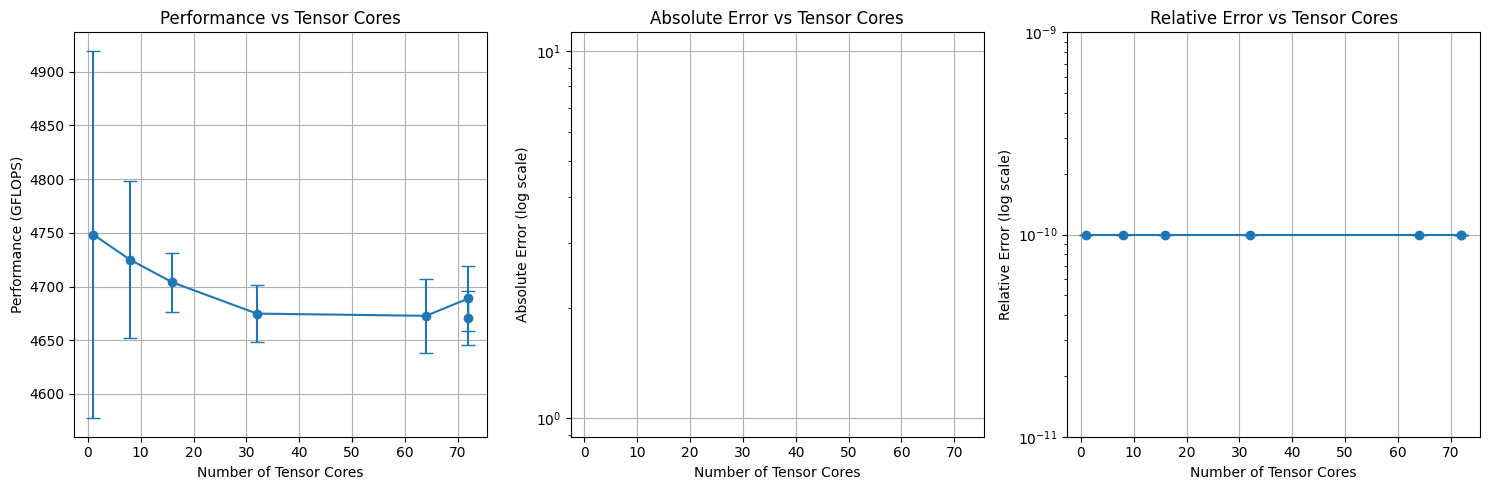

cores: [1, 8, 16, 32, 64, 72, 72]
gflops_mean: [np.float64(4748.443213557869), np.float64(4724.948813698035), np.float64(4703.876674943825), np.float64(4674.791768613378), np.float64(4672.7339246345), np.float64(4688.856792086626), np.float64(4671.01534837688)]
gflops_std: [np.float64(171.21446798609352), np.float64(73.29136241819104), np.float64(27.739074649130263), np.float64(26.6856694998347), np.float64(34.68825003903772), np.float64(30.12731176353446), np.float64(25.057783574190058)]
absolute_error_mean: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
relative_error_mean: [np.float64(9.999999999999996e-11), np.float64(9.999999999999996e-11), np.float64(9.999999999999996e-11), np.float64(9.999999999999996e-11), np.float64(9.999999999999996e-11), np.float64(9.999999999999996e-11), np.float64(9.999999999999996e-11)]


In [16]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from scipy import stats
from tensor_matrix_ops import TensorMatrixOps

class TensorCoreBenchmark:
    def __init__(self, lib_path='./cuda_matlib.so'):
        self.lib = TensorMatrixOps(lib_path)
        self.max_cores = 72
    
    def benchmark_matrix_dot(self, matrix_size, iterations=100):
        """Benchmark matrix dot operation across different numbers of tensor cores"""
        # Generate random matrix in CuPy
        a = cp.random.rand(matrix_size, matrix_size)
        
        results = {
            'cores': [],
            'gflops_mean': [],
            'gflops_std': [],
            'absolute_error_mean': [],
            'absolute_error_std': [],
            'relative_error_mean': [],
            'relative_error_std': []
        }
        
        # Baseline full precision reference
        baseline_result = self.lib.matmul(a, a)
        
        # Test different core counts
        core_range = [1, 8, 16, 32, 64, 72, self.max_cores]
        
        for cores in core_range:
            print(f"Testing with {cores} tensor cores")
            
            # Performance and error tracking
            performance_times = []
            absolute_errors = []
            relative_errors = []
            
            for _ in range(iterations):
                start = time.time()
                result = self.lib.matmul(a, a)
                end = time.time()
                
                # Calculate performance
                gflops = (2.0 * matrix_size**3) / ((end - start) * 1e9)
                performance_times.append(gflops)
                
                # Enhanced error calculation
                abs_error = cp.linalg.norm(result - baseline_result)
                rel_error = abs_error / (cp.linalg.norm(baseline_result) + 1e-10)
                
                absolute_errors.append(abs_error.get())
                relative_errors.append(max(rel_error.get(), 1e-10))
            
            # Store aggregated results with statistical details
            results['cores'].append(cores)
            results['gflops_mean'].append(np.mean(performance_times))
            results['gflops_std'].append(np.std(performance_times))
            results['absolute_error_mean'].append(np.mean(absolute_errors))
            results['absolute_error_std'].append(np.std(absolute_errors))
            results['relative_error_mean'].append(np.mean(relative_errors))
            results['relative_error_std'].append(np.std(relative_errors))
        
        return results
    
    def plot_results(self, results):
        """Plot benchmark results with error bars"""
        plt.figure(figsize=(15, 5))
        
        # Performance subplot
        plt.subplot(1, 3, 1)
        plt.errorbar(results['cores'], results['gflops_mean'], 
                     yerr=results['gflops_std'], marker='o', capsize=5)
        plt.title('Performance vs Tensor Cores')
        plt.xlabel('Number of Tensor Cores')
        plt.ylabel('Performance (GFLOPS)')
        plt.grid(True)
        
        # Absolute Error subplot
        plt.subplot(1, 3, 2)
        plt.errorbar(results['cores'], results['absolute_error_mean'], 
                     yerr=results['absolute_error_std'], marker='o', capsize=5)
        plt.yscale('log')
        plt.title('Absolute Error vs Tensor Cores')
        plt.xlabel('Number of Tensor Cores')
        plt.ylabel('Absolute Error (log scale)')
        plt.grid(True)
        
        # Relative Error subplot
        plt.subplot(1, 3, 3)
        plt.errorbar(results['cores'], results['relative_error_mean'], 
                     yerr=results['relative_error_std'], marker='o', capsize=5)
        plt.yscale('log')
        plt.title('Relative Error vs Tensor Cores')
        plt.xlabel('Number of Tensor Cores')
        plt.ylabel('Relative Error (log scale)')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def run_benchmark(self, matrix_size=2048):
        """Run full benchmark and plot results"""
        results = self.benchmark_matrix_dot(matrix_size)
        self.plot_results(results)
        return results

# Example usage
if __name__ == '__main__':
    benchmark = TensorCoreBenchmark()
    results = benchmark.run_benchmark()
    
    # Print key statistics
    for key in ['cores', 'gflops_mean', 'gflops_std', 
                'absolute_error_mean', 'relative_error_mean']:
        print(f"{key}: {results[key]}")


Benchmarking: Matrix Multiplication
Testing with 1 tensor cores
DEBUG:
a shape: (512, 512), order F: True
b shape: (512, 512), order F: True
c shape: (512, 512), order F: True
M=512, K=512, N=512
DEBUG:
a shape: (512, 512), order F: True
b shape: (512, 512), order F: True
c shape: (512, 512), order F: True
M=512, K=512, N=512
DEBUG:
a shape: (512, 512), order F: True
b shape: (512, 512), order F: True
c shape: (512, 512), order F: True
M=512, K=512, N=512
DEBUG:
a shape: (512, 512), order F: True
b shape: (512, 512), order F: True
c shape: (512, 512), order F: True
M=512, K=512, N=512
DEBUG:
a shape: (512, 512), order F: True
b shape: (512, 512), order F: True
c shape: (512, 512), order F: True
M=512, K=512, N=512
DEBUG:
a shape: (512, 512), order F: True
b shape: (512, 512), order F: True
c shape: (512, 512), order F: True
M=512, K=512, N=512
DEBUG:
a shape: (512, 512), order F: True
b shape: (512, 512), order F: True
c shape: (512, 512), order F: True
M=512, K=512, N=512
DEBUG:
a sh

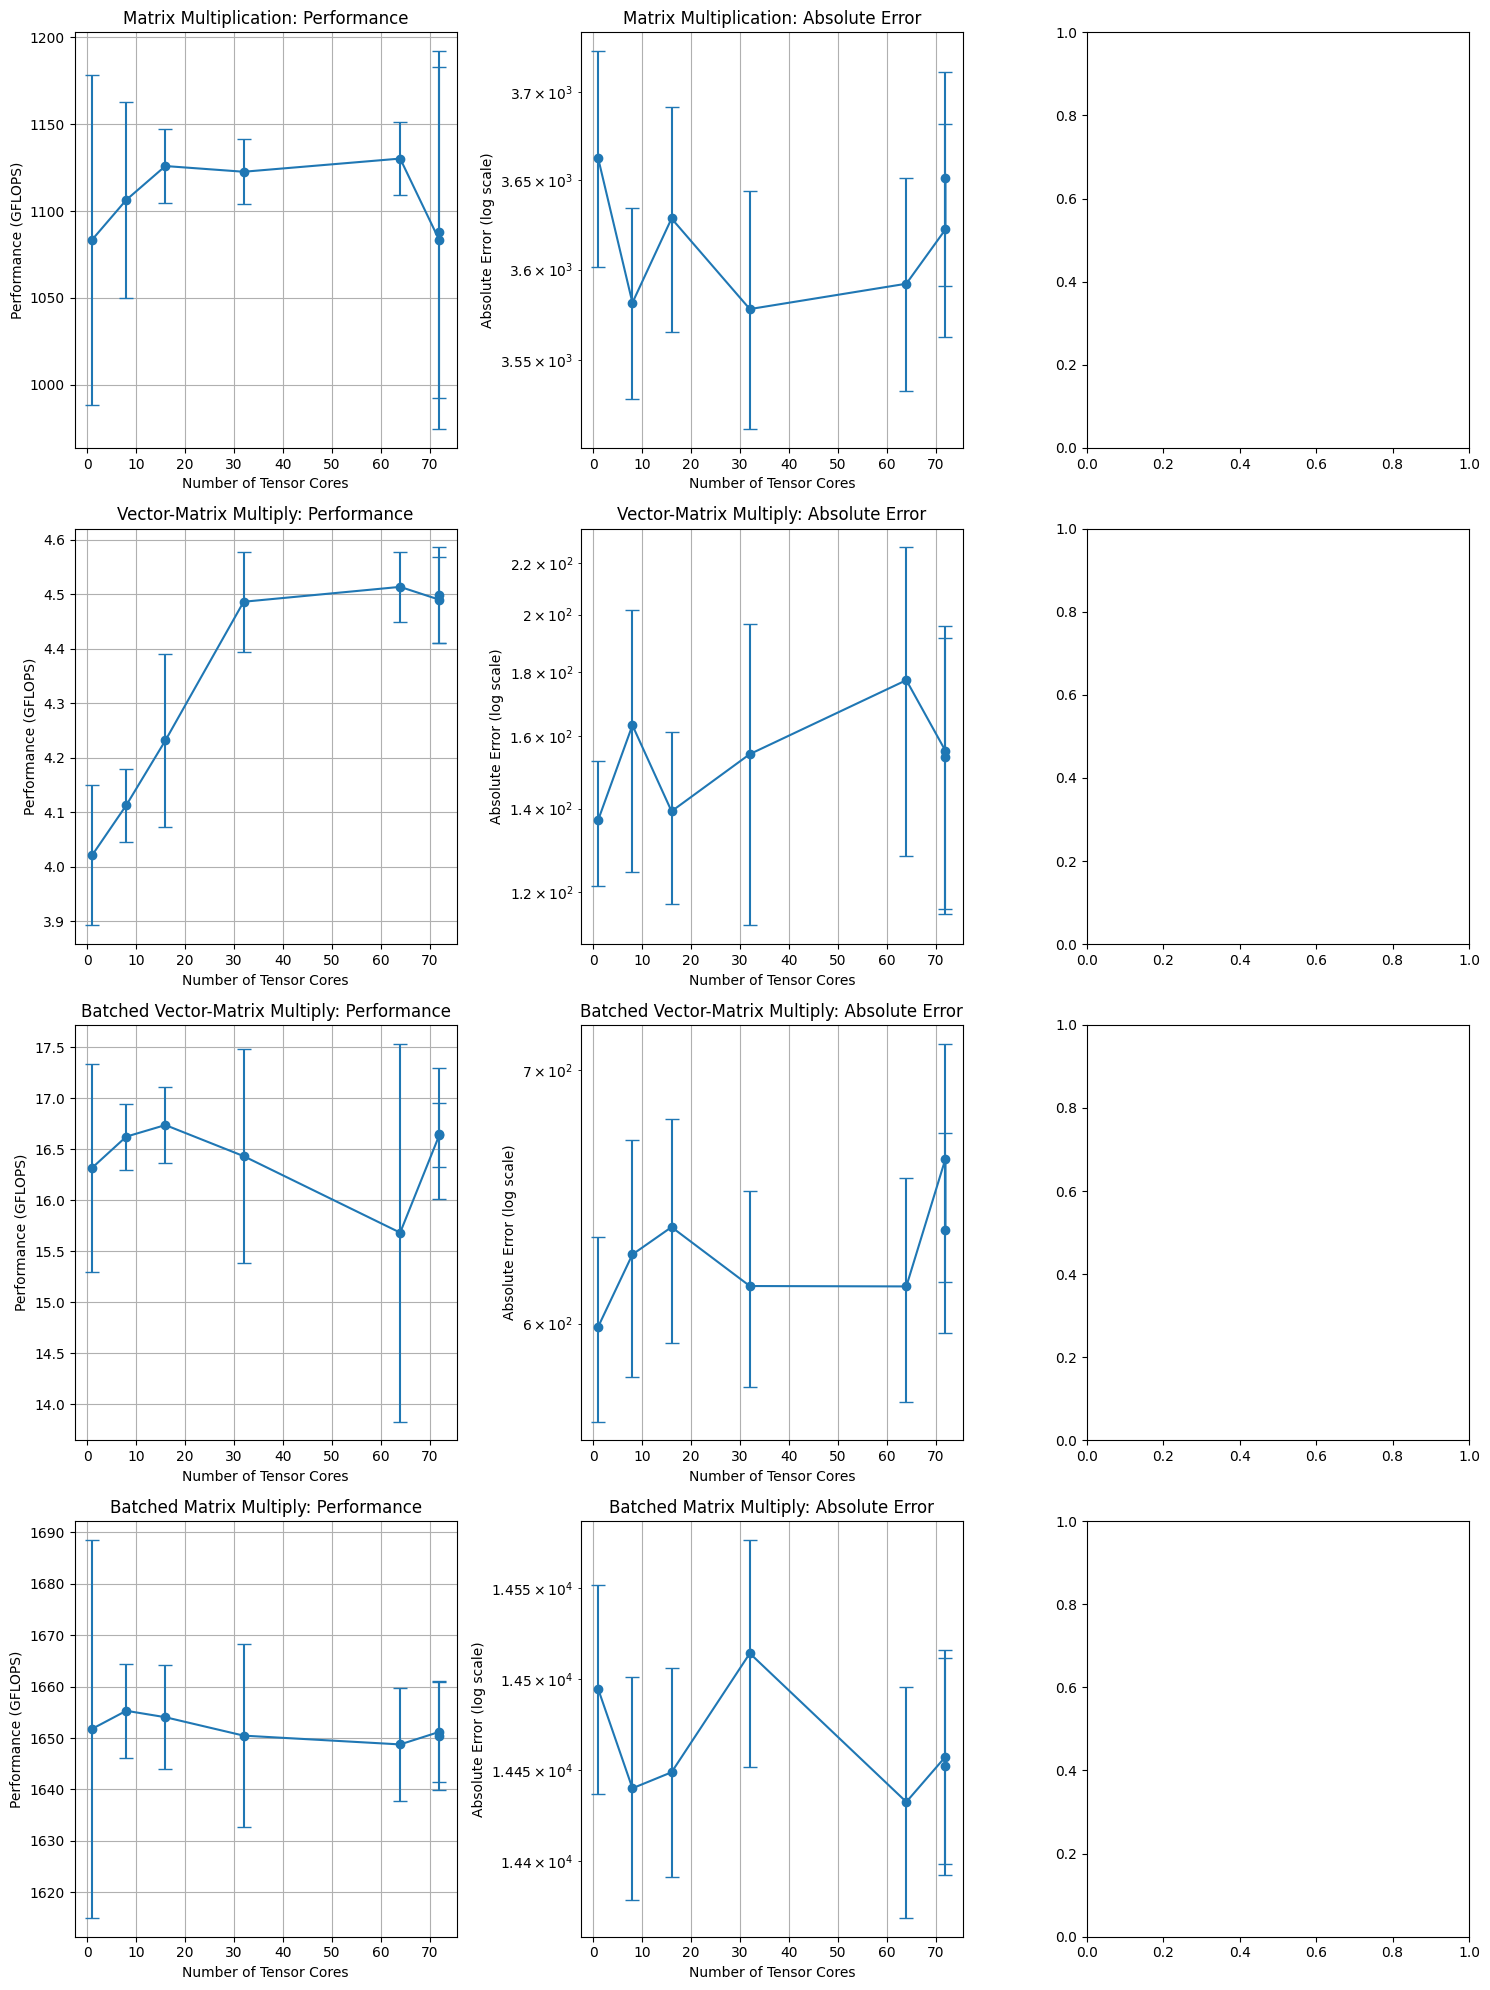

In [2]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tensor_matrix_ops import TensorMatrixOps

class MultiOpTensorCoreBenchmark:
    def __init__(self, lib_path='./cuda_matlib.so'):
        self.lib = TensorMatrixOps(lib_path)
        self.max_cores = 72
    
    def benchmark_operations(self, matrix_size=512, iterations=100):
        """Benchmark multiple matrix operations across tensor core counts"""
        # Operations to test
        operations = [
            ('Matrix Multiplication', self._matrix_multiply),
            ('Vector-Matrix Multiply', self._vector_matrix_multiply),
            ('Batched Vector-Matrix Multiply', self._batched_vector_matrix_multiply),
            ('Batched Matrix Multiply', self._batched_matrix_multiply)
        ]
        
        # Core range to test
        core_range = [1, 8, 16, 32, 64, 72, self.max_cores]
        
        # Store comprehensive results
        all_results = {}
        
        for op_name, op_func in operations:
            print(f"\nBenchmarking: {op_name}")
            results = {
                'cores': [],
                'gflops_mean': [],
                'gflops_std': [],
                'absolute_error_mean': [],
                'absolute_error_std': []
            }
            
            # Prepare input data
            input_data = op_func('prepare', matrix_size)
            
            for cores in core_range:
                print(f"Testing with {cores} tensor cores")
                
                # Performance and error tracking
                performance_times = []
                absolute_errors = []
                
                # Baseline reference
                baseline_result = op_func('compute', matrix_size)
                
                for _ in range(iterations):
                    start = time.time()
                    result = op_func('compute', matrix_size)
                    end = time.time()
                    
                    # Calculate performance (adjust based on operation)
                    gflops = op_func('performance', matrix_size, start, end)
                    performance_times.append(gflops)
                    
                    # Calculate error
                    abs_error = cp.linalg.norm(result - baseline_result)
                    absolute_errors.append(abs_error.get())
                
                # Store results
                results['cores'].append(cores)
                results['gflops_mean'].append(np.mean(performance_times))
                results['gflops_std'].append(np.std(performance_times))
                results['absolute_error_mean'].append(np.mean(absolute_errors))
                results['absolute_error_std'].append(np.std(absolute_errors))
            
            all_results[op_name] = results
        
        return all_results
    
    def _matrix_multiply(self, mode, matrix_size, start=None, end=None):
        """Matrix multiplication test"""
        if mode == 'prepare':
            return cp.random.rand(matrix_size, matrix_size)
        elif mode == 'compute':
            a = cp.random.rand(matrix_size, matrix_size)
            return self.lib.matmul(a, a)
        elif mode == 'performance':
            return (2.0 * matrix_size**3) / ((end - start) * 1e9)
    
    def _vector_matrix_multiply(self, mode, matrix_size, start=None, end=None):
        """Vector-matrix multiplication test"""
        if mode == 'prepare':
            return cp.random.rand(matrix_size)
        elif mode == 'compute':
            v = cp.random.rand(matrix_size)
            a = cp.random.rand(matrix_size, matrix_size)
            return self.lib.vector_matmul(v, a)
        elif mode == 'performance':
            return (2.0 * matrix_size**2) / ((end - start) * 1e9)
    
    def _batched_vector_matrix_multiply(self, mode, matrix_size, start=None, end=None):
        """Batched vector-matrix multiplication test"""
        batch_size = 16  # Reduced from 32
        if mode == 'prepare':
            return cp.random.rand(matrix_size, batch_size)
        elif mode == 'compute':
            v = cp.random.rand(matrix_size, batch_size)
            a = cp.random.rand(matrix_size, matrix_size)
            return self.lib.batched_vector_matmul(v, a)
        elif mode == 'performance':
            return (2.0 * matrix_size**2 * batch_size) / ((end - start) * 1e9)
    
    def _batched_matrix_multiply(self, mode, matrix_size, start=None, end=None):
        """Batched matrix multiplication test"""
        batch_size = 16  # Reduced from 32
        if mode == 'prepare':
            return cp.random.rand(batch_size, matrix_size, matrix_size)
        elif mode == 'compute':
            a = cp.random.rand(batch_size, matrix_size, matrix_size)
            return self.lib.batched_matmul(a, a)
        elif mode == 'performance':
            return (2.0 * matrix_size**3 * batch_size) / ((end - start) * 1e9)
    
    def plot_results(self, all_results):
        """Plot results for all operations"""
        operations = list(all_results.keys())
        fig, axes = plt.subplots(len(operations), 3, figsize=(15, 5*len(operations)))
        
        for i, (op_name, results) in enumerate(all_results.items()):
            # Performance subplot
            axes[i, 0].errorbar(results['cores'], results['gflops_mean'], 
                                 yerr=results['gflops_std'], marker='o', capsize=5)
            axes[i, 0].set_title(f'{op_name}: Performance')
            axes[i, 0].set_xlabel('Number of Tensor Cores')
            axes[i, 0].set_ylabel('Performance (GFLOPS)')
            axes[i, 0].grid(True)
            
            # Absolute Error subplot
            axes[i, 1].errorbar(results['cores'], results['absolute_error_mean'], 
                                 yerr=results['absolute_error_std'], marker='o', capsize=5)
            axes[i, 1].set_yscale('log')
            axes[i, 1].set_title(f'{op_name}: Absolute Error')
            axes[i, 1].set_xlabel('Number of Tensor Cores')
            axes[i, 1].set_ylabel('Absolute Error (log scale)')
            axes[i, 1].grid(True)
            
            # Print key statistics
            print(f"\n{op_name} Key Statistics:")
            print(f"Cores: {results['cores']}")
            print(f"GFLOPS Mean: {results['gflops_mean']}")
            print(f"Absolute Error Mean: {results['absolute_error_mean']}")
        
        plt.tight_layout()
        plt.show()
    
    def run_benchmark(self, matrix_size=512):
        """Run full benchmark and plot results"""
        results = self.benchmark_operations(matrix_size)
        self.plot_results(results)
        return results

# Example usage
if __name__ == '__main__':
    benchmark = MultiOpTensorCoreBenchmark()
    benchmark.run_benchmark()


Benchmarking matrix size: 256
Testing with 1 tensor cores
Testing with 8 tensor cores
Testing with 16 tensor cores
Testing with 32 tensor cores
Testing with 64 tensor cores
Testing with 72 tensor cores
Testing with 72 tensor cores

Benchmarking matrix size: 512
Testing with 1 tensor cores
Testing with 8 tensor cores
Testing with 16 tensor cores
Testing with 32 tensor cores
Testing with 64 tensor cores
Testing with 72 tensor cores
Testing with 72 tensor cores

Benchmarking matrix size: 1024
Testing with 1 tensor cores
Testing with 8 tensor cores
Testing with 16 tensor cores
Testing with 32 tensor cores
Testing with 64 tensor cores
Testing with 72 tensor cores
Testing with 72 tensor cores

Matrix Size 256 Key Statistics:
Cores: [1, 8, 16, 32, 64, 72, 72]
GFLOPS Mean: [np.float64(3.5838557958492783), np.float64(3.418540514136994), np.float64(3.5476842400191946), np.float64(3.575358252768327), np.float64(3.6493248185381817), np.float64(3.6341742331726965), np.float64(3.5989784292393234)]


/tmp/ipykernel_75375/1202612268.py:91: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i, 1].set_yscale('log')


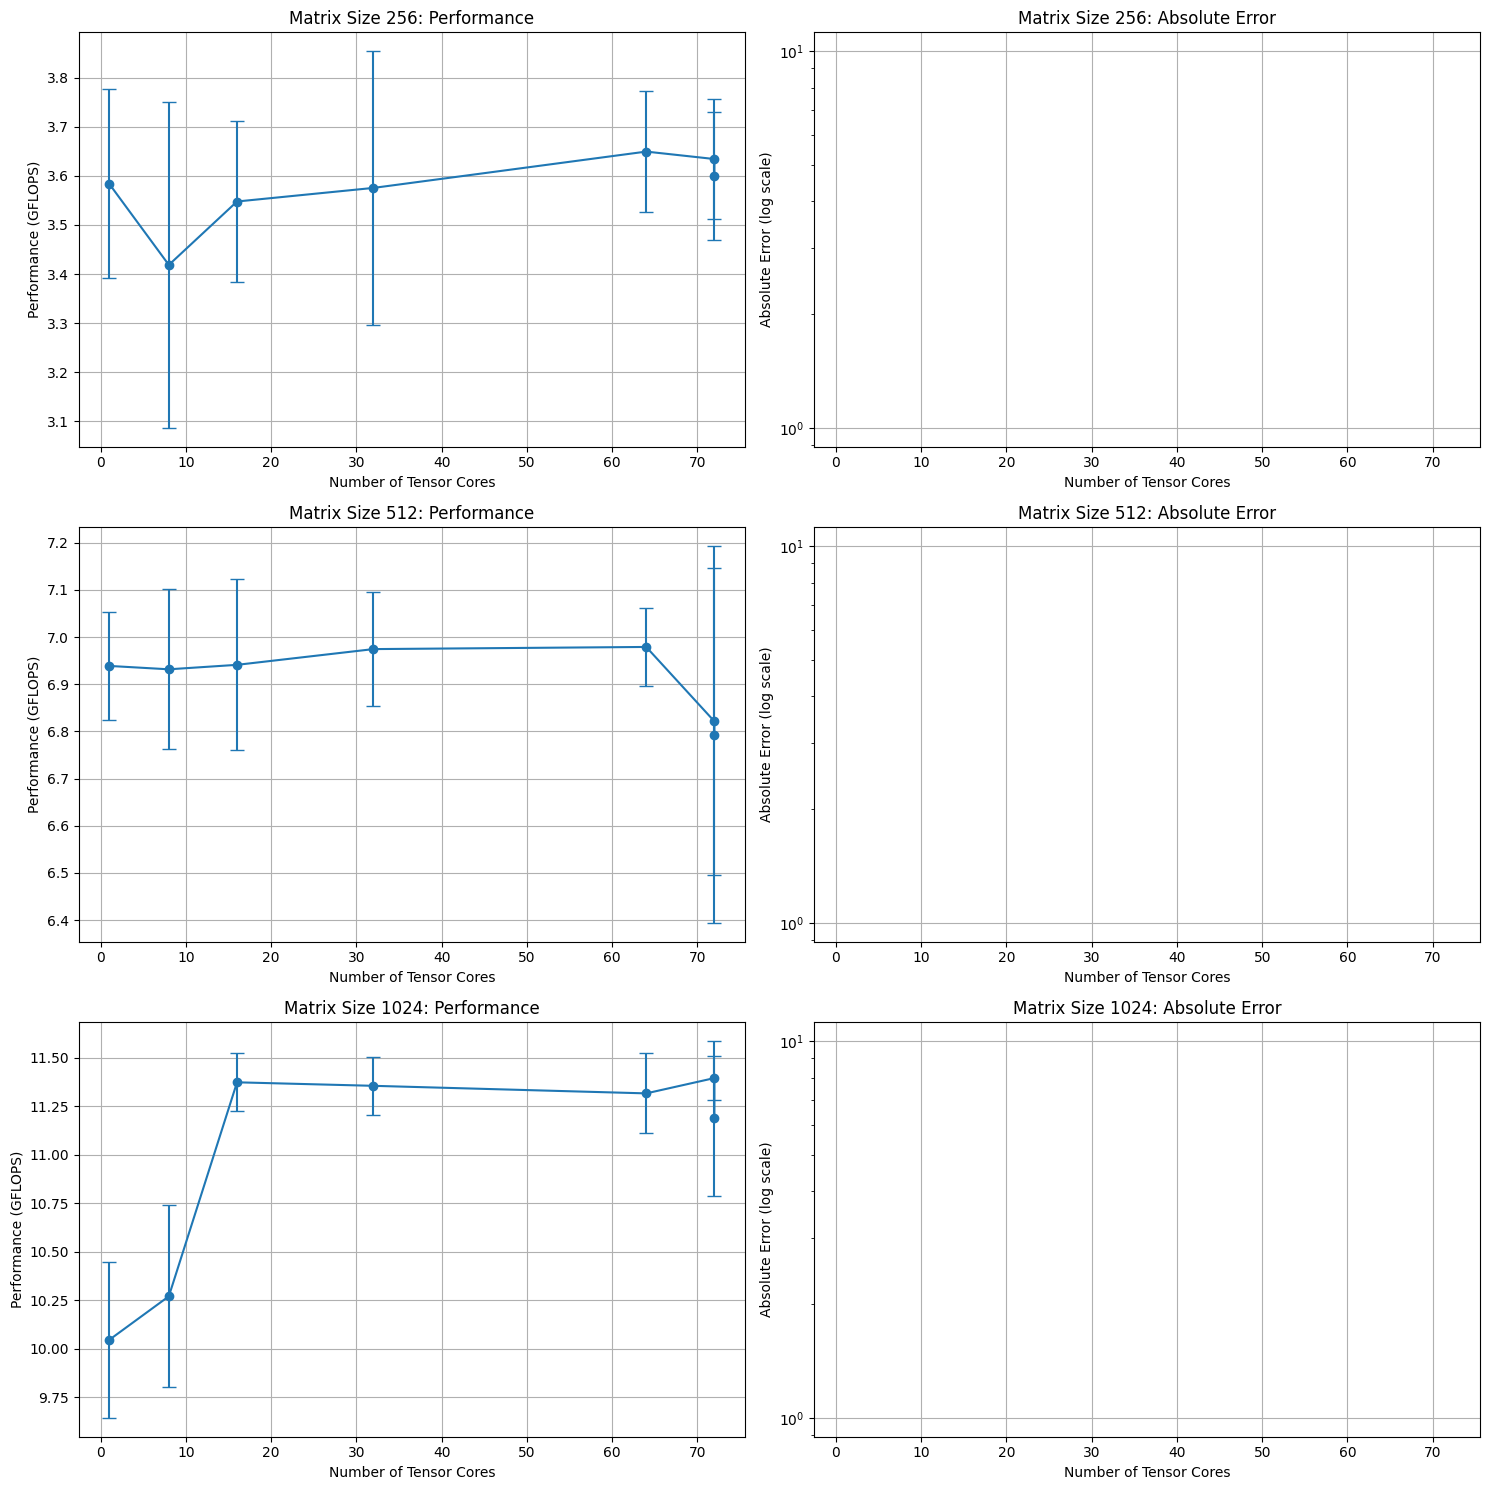

In [5]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tensor_matrix_ops import TensorMatrixOps

class VectorMatrixCoreBenchmark:
    def __init__(self, lib_path='./cuda_matlib.so'):
        self.lib = TensorMatrixOps(lib_path)
        self.max_cores = 72
    
    def flush_gpu_memory(self):
        """Attempt to clear GPU memory"""
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()
    
    def benchmark_vector_matrix_multiply(self, matrix_sizes=[256, 512, 1024], iterations=100):
        """Benchmark vector-matrix multiply across matrix sizes and tensor core counts"""
        results = {}
        
        # Core range to test
        core_range = [1, 8, 16, 32, 64, 72, self.max_cores]
        
        for matrix_size in matrix_sizes:
            print(f"\nBenchmarking matrix size: {matrix_size}")
            
            size_results = {
                'cores': [],
                'gflops_mean': [],
                'gflops_std': [],
                'absolute_error_mean': [],
                'absolute_error_std': []
            }
            
            for cores in core_range:
                self.flush_gpu_memory()
                print(f"Testing with {cores} tensor cores")
                
                # Performance and error tracking
                performance_times = []
                absolute_errors = []
                
                # Prepare inputs
                v = cp.random.rand(matrix_size)
                a = cp.random.rand(matrix_size, matrix_size)
                
                # Baseline reference
                baseline_result = self.lib.vector_matmul(v, a)
                
                for _ in range(iterations):
                    start = time.time()
                    result = self.lib.vector_matmul(v, a)
                    end = time.time()
                    
                    # Calculate performance
                    gflops = (2.0 * matrix_size**2) / ((end - start) * 1e9)
                    performance_times.append(gflops)
                    
                    # Calculate error
                    abs_error = cp.linalg.norm(result - baseline_result)
                    absolute_errors.append(abs_error.get())
                
                # Store results
                size_results['cores'].append(cores)
                size_results['gflops_mean'].append(np.mean(performance_times))
                size_results['gflops_std'].append(np.std(performance_times))
                size_results['absolute_error_mean'].append(np.mean(absolute_errors))
                size_results['absolute_error_std'].append(np.std(absolute_errors))
            
            results[matrix_size] = size_results
        
        return results
    
    def plot_results(self, results):
        """Plot results for different matrix sizes"""
        matrix_sizes = list(results.keys())
        fig, axes = plt.subplots(len(matrix_sizes), 2, figsize=(15, 5*len(matrix_sizes)))
        
        for i, (matrix_size, size_results) in enumerate(results.items()):
            # Performance subplot
            axes[i, 0].errorbar(size_results['cores'], size_results['gflops_mean'], 
                                 yerr=size_results['gflops_std'], marker='o', capsize=5)
            axes[i, 0].set_title(f'Matrix Size {matrix_size}: Performance')
            axes[i, 0].set_xlabel('Number of Tensor Cores')
            axes[i, 0].set_ylabel('Performance (GFLOPS)')
            axes[i, 0].grid(True)
            
            # Absolute Error subplot
            axes[i, 1].errorbar(size_results['cores'], size_results['absolute_error_mean'], 
                                 yerr=size_results['absolute_error_std'], marker='o', capsize=5)
            axes[i, 1].set_yscale('log')
            axes[i, 1].set_title(f'Matrix Size {matrix_size}: Absolute Error')
            axes[i, 1].set_xlabel('Number of Tensor Cores')
            axes[i, 1].set_ylabel('Absolute Error (log scale)')
            axes[i, 1].grid(True)
            
            # Print key statistics
            print(f"\nMatrix Size {matrix_size} Key Statistics:")
            print(f"Cores: {size_results['cores']}")
            print(f"GFLOPS Mean: {size_results['gflops_mean']}")
            print(f"Absolute Error Mean: {size_results['absolute_error_mean']}")
        
        plt.tight_layout()
        plt.show()
    
    def run_benchmark(self):
        """Run full benchmark and plot results"""
        results = self.benchmark_vector_matrix_multiply()
        self.plot_results(results)
        return results

# Example usage
if __name__ == '__main__':
    benchmark = VectorMatrixCoreBenchmark()
    benchmark.run_benchmark()


Benchmarking matrix size: 256
Testing with 1 tensor cores
Testing with 8 tensor cores
Testing with 16 tensor cores
Testing with 32 tensor cores
Testing with 64 tensor cores
Testing with 72 tensor cores
Testing with 72 tensor cores

Benchmarking matrix size: 512
Testing with 1 tensor cores
Testing with 8 tensor cores
Testing with 16 tensor cores
Testing with 32 tensor cores
Testing with 64 tensor cores
Testing with 72 tensor cores
Testing with 72 tensor cores

Benchmarking matrix size: 1024
Testing with 1 tensor cores
Testing with 8 tensor cores
Testing with 16 tensor cores
Testing with 32 tensor cores
Testing with 64 tensor cores
Testing with 72 tensor cores
Testing with 72 tensor cores

Benchmarking matrix size: 2048
Testing with 1 tensor cores
Testing with 8 tensor cores
Testing with 16 tensor cores
Testing with 32 tensor cores
Testing with 64 tensor cores
Testing with 72 tensor cores
Testing with 72 tensor cores

Benchmarking matrix size: 4096
Testing with 1 tensor cores
Testing wi

/tmp/ipykernel_75375/1647849761.py:91: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i, 1].set_yscale('log')



Matrix Size 256 Key Statistics:
Cores: [1, 8, 16, 32, 64, 72, 72]
GFLOPS Mean: [np.float64(3.5469521612048163), np.float64(3.0912450868410253), np.float64(3.5538440842434413), np.float64(3.5931400762993495), np.float64(3.647747364630208), np.float64(3.5992936952222396), np.float64(3.6285374007691855)]
Absolute Error Mean: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]

Matrix Size 512 Key Statistics:
Cores: [1, 8, 16, 32, 64, 72, 72]
GFLOPS Mean: [np.float64(6.909497507224532), np.float64(6.911948700851006), np.float64(6.905741927036879), np.float64(6.9194769083721805), np.float64(6.90984633569577), np.float64(6.941582100213889), np.float64(6.932473126514918)]
Absolute Error Mean: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]

Matrix Size 1024 Key Statistics:
Cores: [1, 8, 16, 32, 64, 72, 72]
GFLOPS Mean: [np.float64(10.094979724675513), np

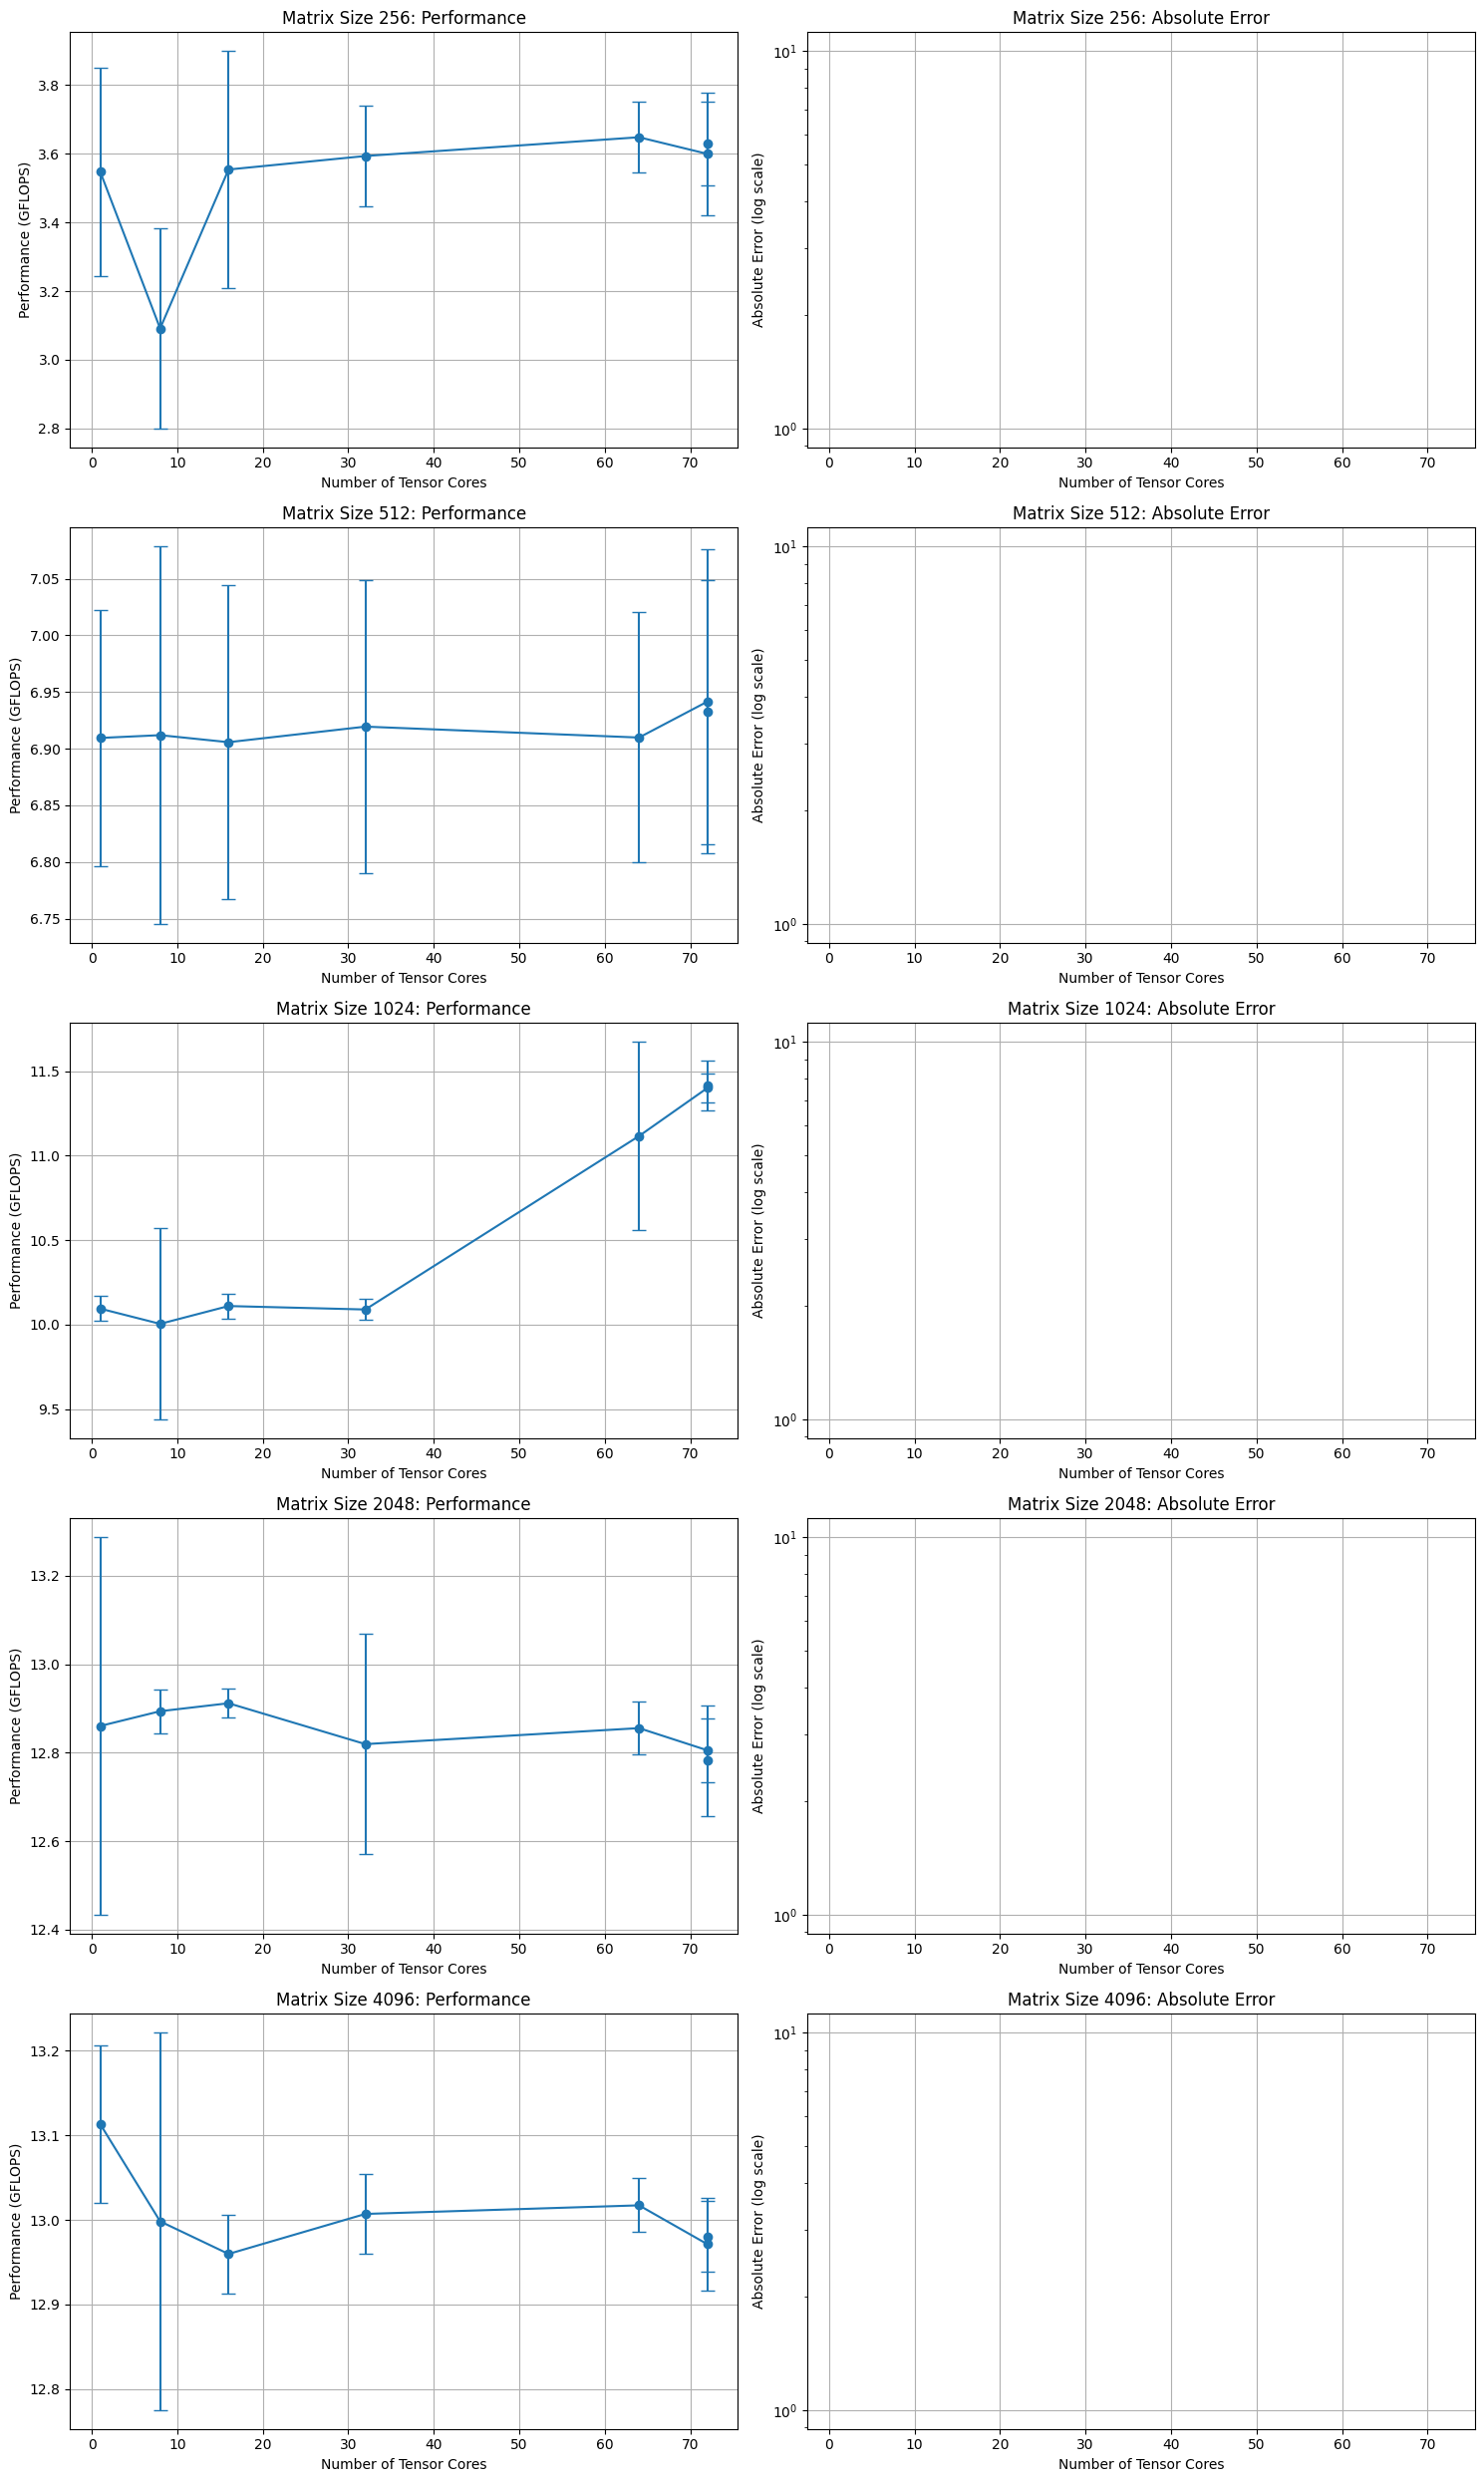

In [6]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tensor_matrix_ops import TensorMatrixOps

class VectorMatrixCoreBenchmark:
    def __init__(self, lib_path='./cuda_matlib.so'):
        self.lib = TensorMatrixOps(lib_path)
        self.max_cores = 72
    
    def flush_gpu_memory(self):
        """Clear GPU memory"""
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()
    
    def benchmark_vector_matrix_multiply(self, matrix_sizes=[256, 512, 1024, 2048, 4096], iterations=100):
        """Benchmark vector-matrix multiply across matrix sizes and tensor core counts"""
        results = {}
        
        # Core range to test
        core_range = [1, 8, 16, 32, 64, 72, self.max_cores]
        
        for matrix_size in matrix_sizes:
            print(f"\nBenchmarking matrix size: {matrix_size}")
            
            size_results = {
                'cores': [],
                'gflops_mean': [],
                'gflops_std': [],
                'absolute_error_mean': [],
                'absolute_error_std': []
            }
            
            for cores in core_range:
                self.flush_gpu_memory()
                print(f"Testing with {cores} tensor cores")
                
                # Performance and error tracking
                performance_times = []
                absolute_errors = []
                
                # Prepare inputs
                v = cp.random.rand(matrix_size)
                a = cp.random.rand(matrix_size, matrix_size)
                
                # Baseline reference
                baseline_result = self.lib.vector_matmul(v, a)
                
                for _ in range(iterations):
                    start = time.time()
                    result = self.lib.vector_matmul(v, a)
                    end = time.time()
                    
                    # Calculate performance
                    gflops = (2.0 * matrix_size**2) / ((end - start) * 1e9)
                    performance_times.append(gflops)
                    
                    # Calculate error
                    abs_error = cp.linalg.norm(result - baseline_result)
                    absolute_errors.append(abs_error.get())
                
                # Store results
                size_results['cores'].append(cores)
                size_results['gflops_mean'].append(np.mean(performance_times))
                size_results['gflops_std'].append(np.std(performance_times))
                size_results['absolute_error_mean'].append(np.mean(absolute_errors))
                size_results['absolute_error_std'].append(np.std(absolute_errors))
            
            results[matrix_size] = size_results
        
        return results
    
    def plot_results(self, results):
        """Plot results for different matrix sizes"""
        matrix_sizes = list(results.keys())
        fig, axes = plt.subplots(len(matrix_sizes), 2, figsize=(15, 5*len(matrix_sizes)))
        
        for i, (matrix_size, size_results) in enumerate(results.items()):
            # Performance subplot
            axes[i, 0].errorbar(size_results['cores'], size_results['gflops_mean'], 
                                 yerr=size_results['gflops_std'], marker='o', capsize=5)
            axes[i, 0].set_title(f'Matrix Size {matrix_size}: Performance')
            axes[i, 0].set_xlabel('Number of Tensor Cores')
            axes[i, 0].set_ylabel('Performance (GFLOPS)')
            axes[i, 0].grid(True)
            
            # Absolute Error subplot
            axes[i, 1].errorbar(size_results['cores'], size_results['absolute_error_mean'], 
                                 yerr=size_results['absolute_error_std'], marker='o', capsize=5)
            axes[i, 1].set_yscale('log')
            axes[i, 1].set_title(f'Matrix Size {matrix_size}: Absolute Error')
            axes[i, 1].set_xlabel('Number of Tensor Cores')
            axes[i, 1].set_ylabel('Absolute Error (log scale)')
            axes[i, 1].grid(True)
            
            # Print key statistics
            print(f"\nMatrix Size {matrix_size} Key Statistics:")
            print(f"Cores: {size_results['cores']}")
            print(f"GFLOPS Mean: {size_results['gflops_mean']}")
            print(f"Absolute Error Mean: {size_results['absolute_error_mean']}")
        
        plt.tight_layout()
        plt.show()
    
    def run_benchmark(self):
        """Run full benchmark and plot results"""
        results = self.benchmark_vector_matrix_multiply()
        self.plot_results(results)
        return results

# Example usage
if __name__ == '__main__':
    benchmark = VectorMatrixCoreBenchmark()
    benchmark.run_benchmark()

In [3]:
import numpy as np
import cupy as cp
import time
from tensor_matrix_ops import TensorMatrixOps

class AccuratePerformanceBenchmark:
    def __init__(self, lib_path='./cuda_matlib.so'):
        self.lib = TensorMatrixOps(lib_path)
    
    def calculate_gflops(self, matrix_size, elapsed_time):
        """
        Accurately calculate GFLOPS for vector-matrix multiplication
        Flops = 2 * m * n (multiply and add operations)
        """
        return (2.0 * matrix_size * matrix_size) / (elapsed_time * 1e9)
    
    def benchmark_vector_matrix_multiply(self, matrix_sizes=[256, 512, 1024, 2048, 4096], iterations=100):
        """Benchmark vector-matrix multiply with precise timing"""
        results = {}
        
        for matrix_size in matrix_sizes:
            # Prepare inputs
            v = cp.random.rand(matrix_size).astype(cp.float64)
            a = cp.random.rand(matrix_size, matrix_size).astype(cp.float64)
            
            # Warm-up runs
            for _ in range(5):
                self.lib.vector_matmul(v, a)
                cp.dot(v, a)
            
            # Tensor Core Performance
            tensor_core_times = []
            for _ in range(iterations):
                # Ensure clean GPU state
                cp.cuda.Stream.null.synchronize()
                
                start = time.time()
                self.lib.vector_matmul(v, a)
                cp.cuda.Stream.null.synchronize()
                end = time.time()
                
                tensor_core_times.append(end - start)
            
            # CuPy Performance
            cupy_times = []
            for _ in range(iterations):
                # Ensure clean GPU state
                cp.cuda.Stream.null.synchronize()
                
                start = time.time()
                cp.dot(v, a)
                cp.cuda.Stream.null.synchronize()
                end = time.time()
                
                cupy_times.append(end - start)
            
            # Calculate GFLOPS
            results[matrix_size] = {
                'tensor_core_gflops': [self.calculate_gflops(matrix_size, t) for t in tensor_core_times],
                'cupy_gflops': [self.calculate_gflops(matrix_size, t) for t in cupy_times]
            }
        
        return self.summarize_results(results)
    
    def summarize_results(self, results):
        """Summarize performance results"""
        summary = {}
        for matrix_size, perf_data in results.items():
            summary[matrix_size] = {
                'tensor_core': {
                    'mean': np.mean(perf_data['tensor_core_gflops']),
                    'std': np.std(perf_data['tensor_core_gflops'])
                },
                'cupy': {
                    'mean': np.mean(perf_data['cupy_gflops']),
                    'std': np.std(perf_data['cupy_gflops'])
                }
            }
            
            print(f"\nMatrix Size {matrix_size}:")
            print(f"Tensor Core GFLOPS: {summary[matrix_size]['tensor_core']['mean']:.2f} ± {summary[matrix_size]['tensor_core']['std']:.2f}")
            print(f"CuPy GFLOPS:        {summary[matrix_size]['cupy']['mean']:.2f} ± {summary[matrix_size]['cupy']['std']:.2f}")
        
        return summary
    
    def run_benchmark(self):
        """Run full benchmark"""
        return self.benchmark_vector_matrix_multiply()

# Example usage
if __name__ == '__main__':
    benchmark = AccuratePerformanceBenchmark()
    benchmark.run_benchmark()


Matrix Size 256:
Tensor Core GFLOPS: 3.57 ± 0.25
CuPy GFLOPS:        6.86 ± 0.99

Matrix Size 512:
Tensor Core GFLOPS: 6.91 ± 0.09
CuPy GFLOPS:        17.45 ± 1.30

Matrix Size 1024:
Tensor Core GFLOPS: 9.90 ± 0.46
CuPy GFLOPS:        34.95 ± 2.62

Matrix Size 2048:
Tensor Core GFLOPS: 11.19 ± 0.05
CuPy GFLOPS:        47.55 ± 1.63

Matrix Size 4096:
Tensor Core GFLOPS: 12.63 ± 0.70
CuPy GFLOPS:        48.20 ± 1.26



--- Matrix Power Performance Benchmark ---

Matrix Size 256:
Tensor Core GFLOPS: 381.15 ± 152.02
CuPy GFLOPS:        66.45 ± 23.40
Speedup:            5.74x

Matrix Size 512:
Tensor Core GFLOPS: 1533.52 ± 479.37
CuPy GFLOPS:        84.99 ± 1.26
Speedup:            18.04x

Matrix Size 1024:
Tensor Core GFLOPS: 2979.23 ± 330.96
CuPy GFLOPS:        90.97 ± 5.74
Speedup:            32.75x

Matrix Size 2048:
Tensor Core GFLOPS: 5664.02 ± 248.12
CuPy GFLOPS:        106.60 ± 1.28
Speedup:            53.13x

--- Matrix Multiply Performance Benchmark ---

Matrix Size 256:
Tensor Core GFLOPS: 291.74 ± 116.24
CuPy GFLOPS:        98.92 ± 6.11
Speedup:            2.95x

Matrix Size 512:
Tensor Core GFLOPS: 1134.61 ± 253.78
CuPy GFLOPS:        103.55 ± 1.92
Speedup:            10.96x

Matrix Size 1024:
Tensor Core GFLOPS: 2272.25 ± 146.64
CuPy GFLOPS:        106.73 ± 0.07
Speedup:            21.29x

Matrix Size 2048:
Tensor Core GFLOPS: 4160.86 ± 126.27
CuPy GFLOPS:        106.85 ± 0.91
Speedup:   

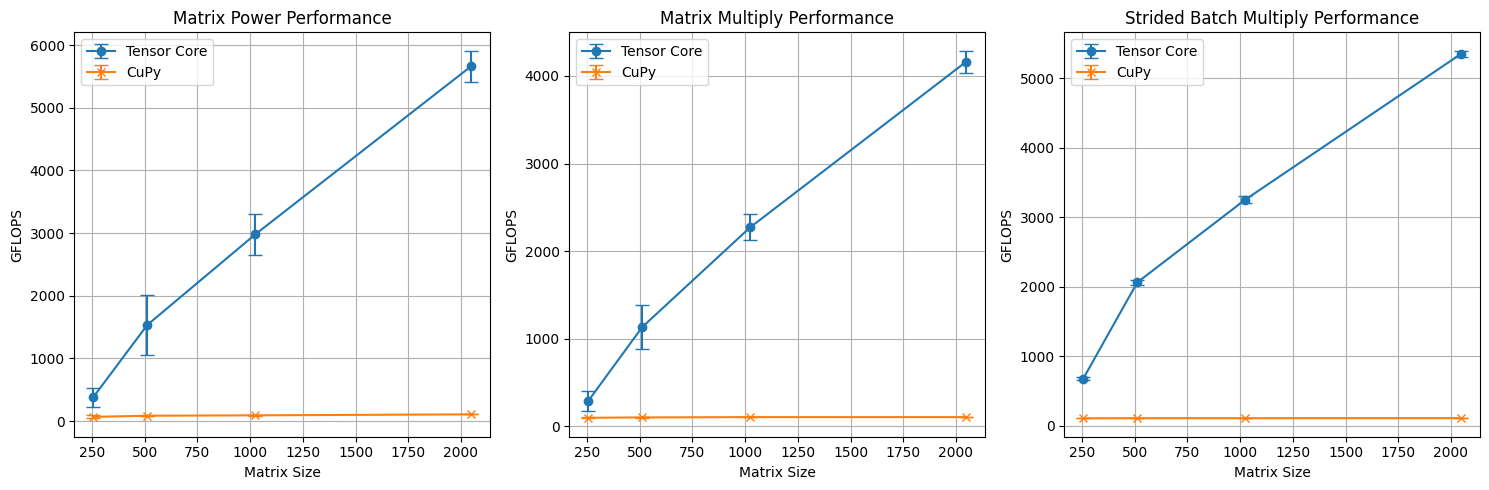

In [1]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tensor_matrix_ops import TensorMatrixOps

class ComprehensivePerformanceBenchmark:
    def __init__(self, lib_path='./cuda_matlib.so'):
        self.lib = TensorMatrixOps(lib_path)
    
    def benchmark_operations(self, matrix_sizes=[256, 512, 1024, 2048], iterations=10):
        """Benchmark different matrix operations"""
        operations = {
            'Matrix Power': self._matrix_power_benchmark,
            'Matrix Multiply': self._matmul_benchmark,
            'Strided Batch Multiply': self._strided_batch_benchmark
        }
        
        all_results = {}
        
        for op_name, benchmark_func in operations.items():
            print(f"\nBenchmarking: {op_name}")
            all_results[op_name] = benchmark_func(matrix_sizes, iterations)
        
        self._plot_comprehensive_results(all_results)
        return all_results
    
    def _matrix_power_benchmark(self, matrix_sizes, iterations):
        results = {}
        for matrix_size in matrix_sizes:
            a = cp.random.rand(matrix_size, matrix_size).astype(cp.float64)
            power = 2
            
            # Tensor Core Performance
            tensor_core_times = self._time_operation(
                lambda: self.lib.matrix_power(a, power), 
                iterations
            )
            
            # CuPy Performance
            cupy_times = self._time_operation(
                lambda: cp.linalg.matrix_power(a, power), 
                iterations
            )
            
            results[matrix_size] = {
                'tensor_core_gflops': [self._calculate_gflops(matrix_size, t, 'matrix_power') for t in tensor_core_times],
                'cupy_gflops': [self._calculate_gflops(matrix_size, t, 'matrix_power') for t in cupy_times]
            }
        
        return results
    
    def _matmul_benchmark(self, matrix_sizes, iterations):
        results = {}
        for matrix_size in matrix_sizes:
            a = cp.random.rand(matrix_size, matrix_size).astype(cp.float64)
            b = cp.random.rand(matrix_size, matrix_size).astype(cp.float64)
            
            # Tensor Core Performance
            tensor_core_times = self._time_operation(
                lambda: self.lib.matmul(a, b), 
                iterations
            )
            
            # CuPy Performance
            cupy_times = self._time_operation(
                lambda: cp.dot(a, b), 
                iterations
            )
            
            results[matrix_size] = {
                'tensor_core_gflops': [self._calculate_gflops(matrix_size, t, 'matmul') for t in tensor_core_times],
                'cupy_gflops': [self._calculate_gflops(matrix_size, t, 'matmul') for t in cupy_times]
            }
        
        return results
    
    def _strided_batch_benchmark(self, matrix_sizes, iterations):
        results = {}
        for matrix_size in matrix_sizes:
            batch_size = 32
            a = cp.random.rand(batch_size, matrix_size, matrix_size).astype(cp.float64)
            b = cp.random.rand(batch_size, matrix_size, matrix_size).astype(cp.float64)
            
            # Tensor Core Performance
            tensor_core_times = self._time_operation(
                lambda: self.lib.batched_matmul(a, b), 
                iterations
            )
            
            # CuPy Performance
            cupy_times = self._time_operation(
                lambda: cp.matmul(a, b), 
                iterations
            )
            
            results[matrix_size] = {
                'tensor_core_gflops': [self._calculate_gflops(matrix_size, t, 'strided_batch') for t in tensor_core_times],
                'cupy_gflops': [self._calculate_gflops(matrix_size, t, 'strided_batch') for t in cupy_times]
            }
        
        return results
    
    def _time_operation(self, operation, iterations):
        times = []
        for _ in range(iterations):
            cp.cuda.Stream.null.synchronize()
            start = time.time()
            operation()
            cp.cuda.Stream.null.synchronize()
            end = time.time()
            times.append(end - start)
        return times
    
    def _calculate_gflops(self, matrix_size, elapsed_time, operation_type):
        """Calculate GFLOPS based on operation type"""
        if operation_type == 'matrix_power':
            return (2.0 * matrix_size**3) / (elapsed_time * 1e9)
        elif operation_type == 'matmul':
            return (2.0 * matrix_size**3) / (elapsed_time * 1e9)
        elif operation_type == 'strided_batch':
            batch_size = 32
            return (2.0 * matrix_size**3 * batch_size) / (elapsed_time * 1e9)
        else:
            raise ValueError(f"Unsupported operation type: {operation_type}")
    
    def _plot_comprehensive_results(self, results):
        """Create a comprehensive performance plot"""
        plt.figure(figsize=(15, 5))
        
        # Prepare data for plotting
        matrix_sizes = list(list(results.values())[0].keys())
        operations = list(results.keys())
        
        # Create subplot for each operation type
        for i, op_name in enumerate(operations):
            tensor_core_means = [np.mean(results[op_name][size]['tensor_core_gflops']) for size in matrix_sizes]
            tensor_core_stds = [np.std(results[op_name][size]['tensor_core_gflops']) for size in matrix_sizes]
            cupy_means = [np.mean(results[op_name][size]['cupy_gflops']) for size in matrix_sizes]
            cupy_stds = [np.std(results[op_name][size]['cupy_gflops']) for size in matrix_sizes]
            
            plt.subplot(1, 3, i+1)
            plt.errorbar(matrix_sizes, tensor_core_means, yerr=tensor_core_stds, 
                         fmt='o-', label='Tensor Core', capsize=5)
            plt.errorbar(matrix_sizes, cupy_means, yerr=cupy_stds, 
                         fmt='x-', label='CuPy', capsize=5)
            
            plt.title(f'{op_name} Performance')
            plt.xlabel('Matrix Size')
            plt.ylabel('GFLOPS')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def run_benchmark(self):
        """Run full benchmark"""
        return self.benchmark_operations()
        
    def benchmark_operations(self, matrix_sizes=[256, 512, 1024, 2048], iterations=10):
        """Benchmark different matrix operations"""
        operations = {
            'Matrix Power': self._matrix_power_benchmark,
            'Matrix Multiply': self._matmul_benchmark,
            'Strided Batch Multiply': self._strided_batch_benchmark
        }
        
        all_results = {}
        
        for op_name, benchmark_func in operations.items():
            print(f"\n--- {op_name} Performance Benchmark ---")
            results = benchmark_func(matrix_sizes, iterations)
            
            # Print detailed results
            for matrix_size, perf_data in results.items():
                tensor_core_gflops = perf_data['tensor_core_gflops']
                cupy_gflops = perf_data['cupy_gflops']
                
                print(f"\nMatrix Size {matrix_size}:")
                print(f"Tensor Core GFLOPS: {np.mean(tensor_core_gflops):.2f} ± {np.std(tensor_core_gflops):.2f}")
                print(f"CuPy GFLOPS:        {np.mean(cupy_gflops):.2f} ± {np.std(cupy_gflops):.2f}")
                print(f"Speedup:            {np.mean(tensor_core_gflops) / np.mean(cupy_gflops):.2f}x")
            
            all_results[op_name] = results
        
        self._plot_comprehensive_results(all_results)
        return all_results
    

# Example usage
if __name__ == '__main__':
    benchmark = ComprehensivePerformanceBenchmark()
    benchmark.run_benchmark()